## 1) Data Preparation ##

In [2]:
import numpy as np
import pandas as pd

In [3]:
file_path = "/Users/zhenghuichen/Desktop/CS229 HW/CS229 Final Project/cleaned_weather_ds_v1.csv"
data = pd.read_csv(file_path)

print(data.head())

   Unnamed: 0  county  year  month  temperature  soil_temperature_layer_1  \
0       12360  Fresno  1990      1     3.691191                  4.663884   
1       12361  Fresno  1990      2     4.050741                  5.475378   
2       12362  Fresno  1990      3     8.839996                  9.442420   
3       12363  Fresno  1990      4    13.324305                 13.928642   
4       12364  Fresno  1990      5    14.855897                 16.208089   

    latitude   longitude  wind_speed  dewpoint_temperature  ...  \
0  36.758328 -119.648468    1.711429             -2.031155  ...   
1  36.758328 -119.648468    1.977157             -2.552265  ...   
2  36.758328 -119.648468    1.859745              1.245001  ...   
3  36.758328 -119.648468    2.001287              4.051747  ...   
4  36.758328 -119.648468    2.164857              3.505000  ...   

   low_veg_cover  potential_evaporation    runoff  skin_reservoir_content  \
0       0.500237              -1.292949  0.156505        

In [95]:
########### Creating Anomalies ############

# Historical averages from data before 2016
data_temp_bef_2016 = data[data["year"] < 2016]
month_avg = (
    data_temp_bef_2016
    .groupby(["county", "month"], as_index=False)["temperature"]
    .mean()
    .rename(columns={"temperature": "hist_temp_avg"})
)

# Merge and compute anomalies for data before 2016
data_temp_bef_2016 = pd.merge(data_temp_bef_2016, month_avg, on=["county", "month"])
data_temp_bef_2016["temp_anom"] = data_temp_bef_2016["temperature"] - data_temp_bef_2016["hist_temp_avg"]

# Merge and compute anomalies for data from 2016 onwards
data_temp_after_2016 = data[data["year"] >= 2016]
data_temp_after_2016 = pd.merge(data_temp_after_2016, month_avg, on=["county", "month"])
data_temp_after_2016["temp_anom"] = data_temp_after_2016["temperature"] - data_temp_after_2016["hist_temp_avg"]

# Finally, combine the two datasets
data = pd.concat([data_temp_bef_2016, data_temp_after_2016], ignore_index=True)

# Sort the data by county, year, and month
data = data.sort_values(by=["county", "year", "month"])

########### Creating the Lag 12 Baseline ############

# Function to create lagged variables
def create_lagged_variables(data, lagged_vars, lags):
    for var in lagged_vars:
        for lag in lags:
            data[f"{var}_lag_{lag}"] = data.groupby("county")[var].shift(lag)
    return data

# Create lagged variables for temperature anomalies
lagged_vars = ["temp_anom"]
prev_yr_lags = [12]  # Create a 12-month lag
data = create_lagged_variables(data, lagged_vars, prev_yr_lags)

### Create list of variables to fit the model ###
fit_vars = data.columns.to_list()

# Remove irrelevant columns
irrelevant_columns = ["year", "county", "temperature", "Unnamed: 0"]
for col in irrelevant_columns:
    if col in fit_vars:
        fit_vars.remove(col)

# # Drop columns from data that are not in fit_vars (keep data the same)
# data = data[fit_vars]

# Check if the modified dataset looks right
print("Features to fit the model:", fit_vars)
print(data.head())
print(data.shape)

# # Check values of a column (everything exists)
# print(data["hist_temp_avg"].head())  # First 5 rows
# print(data["hist_temp_avg"].tail())  # Last 5 rows

Features to fit the model: ['month', 'soil_temperature_layer_1', 'latitude', 'longitude', 'wind_speed', 'dewpoint_temperature', 'hi_veg_cover', 'leaf_area_index_hi_veg', 'leaf_area_index_lo_veg', 'low_veg_cover', 'potential_evaporation', 'runoff', 'skin_reservoir_content', 'surface_pressure', 'surface_runoff', 'precipitation', 'volumetric_soil_water_layer_1', 'relative_humidity', 'vapor_pressure_diff', 'temperature_L1', 'temperature_L6', 'temperature_L12', 'soil_temperature_layer_1_L12', 'hist_temp_avg', 'temp_anom', 'temp_anom_lag_12']
   Unnamed: 0  county  year  month  temperature  soil_temperature_layer_1  \
0       12372  Fresno  1991      1     4.310543                  4.357532   
1       12373  Fresno  1991      2     8.730227                  8.245149   
2       12374  Fresno  1991      3     5.374808                  7.242619   
3       12375  Fresno  1991      4     9.930297                 10.385421   
4       12376  Fresno  1991      5    12.710383                 13.78728

## 2) AutoBNN Model ##

In [5]:
%pip install autobnn

import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from autobnn import estimators, operators, kernels, likelihoods, training_util
from sklearn.preprocessing import StandardScaler

seed = jax.random.PRNGKey(0)

Note: you may need to restart the kernel to use updated packages.


# a) Model Trained on Temp_anom_lag_12 Feature With 8 Ensembles #

In [26]:
from sklearn.preprocessing import RobustScaler

fit_vars = ["temp_anom_lag_12"]  

# Print selected features
print(f"Features used for training: {fit_vars}")

# Initialize best model tracking
best_model = None
best_score = float("inf")

validation_years = range(2018, 2024)

for validation_year in validation_years:
    # print(f"\n🔵 Training on data up to {validation_year - 1}, Testing on {validation_year}")

    # Split into training and validation
    train_data = data[data["year"] < validation_year]
    val_data = data[data["year"] == validation_year]

    # Extract target variable (temperature anomaly)
    y_train = train_data["temp_anom"].values.astype(np.float32)
    y_val = val_data["temp_anom"].values.astype(np.float32)

    if y_train.ndim == 1:
        y_train = y_train[:, None]
    if y_val.ndim == 1:
        y_val = y_val[:, None]

    # Extract and normalize features
    X_train = train_data[fit_vars].values.astype(np.float32)
    X_val = val_data[fit_vars].values.astype(np.float32)

    # Fix: Fill NaN values in temp_anom_lag_12
    train_data = train_data.copy()
    val_data = val_data.copy()
    train_data.loc[:, "temp_anom_lag_12"] = train_data["temp_anom_lag_12"].fillna(train_data["temp_anom_lag_12"].mean())
    val_data.loc[:, "temp_anom_lag_12"] = val_data["temp_anom_lag_12"].fillna(train_data["temp_anom_lag_12"].mean())

    # Scale features
    # scaler = StandardScaler()
    # # X_train_scaled = scaler.fit_transform(train_data[fit_vars].values.astype(np.float32))
    # # X_val_scaled = scaler.transform(val_data[fit_vars].values.astype(np.float32))

    # X_train_scaled = scaler.fit_transform(train_data[fit_vars])
    # X_val_scaled = scaler.transform(val_data[fit_vars])

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(train_data[fit_vars])
    X_val_scaled = scaler.transform(val_data[fit_vars])

    # print("New X_train_scaled min/max:", np.min(X_train_scaled), np.max(X_train_scaled))

    # Generate time indices
    x_train = np.arange(len(y_train), dtype=np.float32)
    x_val = np.arange(len(y_train), len(y_train) + len(y_val), dtype=np.float32)

    # Normalize time indices (0 to 1)
    x_scale = x_train.max()
    x_train = x_train / x_scale
    x_val = x_val / x_scale

    # Define periodic component (yearly seasonality)
    one_year = jnp.array(12. / x_scale, dtype=jnp.float32)

    # Combine time indices with weather features for AutoBNN input
    x_train_combined = np.concatenate([x_train[:, None], X_train_scaled], axis=1)
    x_val_combined = np.concatenate([x_val[:, None], X_val_scaled], axis=1)

    seed = jax.random.PRNGKey(0)
    est = estimators.AutoBnnMapEstimator(
        model_or_name='sum_of_products',
        likelihood_model='normal_likelihood_logistic_noise',
        seed=seed,
        periods=(one_year,),
        num_particles=8,
    )

    est = est.fit(x_train_combined, y_train)

    lo, mid, p90, hi = est.predict_quantiles(x_val_combined, q=[2.5, 50.0, 90.0, 97.5])

    # Compute a simple evaluation metric (Negative Log-Likelihood, NLL)
    nll = -np.mean(np.log(hi - lo))  # Placeholder metric

    # print(f"🟢 Validation Year {validation_year}: NLL Score = {nll:.4f}")

    if nll < best_score:
        best_score = nll
        best_model = est
        # print(f"🔥 New Best Model Found (Year {validation_year}) with NLL = {best_score:.4f}")

import pickle
with open("temp_anom_lag_12_autobnn_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# print("\n✅ Best Model Saved Successfully!")

Features used for training: ['temp_anom_lag_12']

🔵 Training on data up to 2017, Testing on 2018
New X_train_scaled min/max: -2.9824909944394014 2.748438573339126


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


🟢 Validation Year 2018: NLL Score = -1.6045
🔥 New Best Model Found (Year 2018) with NLL = -1.6045

🔵 Training on data up to 2018, Testing on 2019
New X_train_scaled min/max: -2.97654264293302 2.7008397250495784
🟢 Validation Year 2019: NLL Score = -1.5896

🔵 Training on data up to 2019, Testing on 2020
New X_train_scaled min/max: -3.0184476301080134 2.7075074990401715
🟢 Validation Year 2020: NLL Score = -1.5863

🔵 Training on data up to 2020, Testing on 2021
New X_train_scaled min/max: -3.010151714672463 2.6925327397632652
🟢 Validation Year 2021: NLL Score = -1.6106
🔥 New Best Model Found (Year 2021) with NLL = -1.6106

🔵 Training on data up to 2021, Testing on 2022
New X_train_scaled min/max: -3.0320430790354918 2.674687564640638
🟢 Validation Year 2022: NLL Score = -1.6117
🔥 New Best Model Found (Year 2022) with NLL = -1.6117

🔵 Training on data up to 2022, Testing on 2023
New X_train_scaled min/max: -3.0269238331171393 2.644327534576554
🟢 Validation Year 2023: NLL Score = -1.6045

✅ B

# b) Model Trained on Temp_anom_lag_12, Month, and Year Feature With 8 Ensembles #

In [124]:
from sklearn.preprocessing import RobustScaler

fit_vars = ["year", "month", "temp_anom_lag_12"]  

# Print selected features
print(f"Features used for training: {fit_vars}")

# Initialize best model tracking
best_model = None
best_score = float("inf")

validation_years = range(2018, 2024)

for validation_year in validation_years:
    # print(f"\n🔵 Training on data up to {validation_year - 1}, Testing on {validation_year}")

    # Split into training and validation
    train_data = data[data["year"] < validation_year]
    val_data = data[data["year"] == validation_year]

    # Extract target variable (temperature anomaly)
    y_train = train_data["temp_anom"].values.astype(np.float32)
    y_val = val_data["temp_anom"].values.astype(np.float32)

    if y_train.ndim == 1:
        y_train = y_train[:, None]
    if y_val.ndim == 1:
        y_val = y_val[:, None]

    # Extract and normalize features
    X_train = train_data[fit_vars].values.astype(np.float32)
    X_val = val_data[fit_vars].values.astype(np.float32)

    # Fix: Fill NaN values in temp_anom_lag_12
    train_data = train_data.copy()
    val_data = val_data.copy()
    train_data.loc[:, "temp_anom_lag_12"] = train_data["temp_anom_lag_12"].fillna(train_data["temp_anom_lag_12"].mean())
    val_data.loc[:, "temp_anom_lag_12"] = val_data["temp_anom_lag_12"].fillna(train_data["temp_anom_lag_12"].mean())

    # Scale features
    # scaler = StandardScaler()
    # # X_train_scaled = scaler.fit_transform(train_data[fit_vars].values.astype(np.float32))
    # # X_val_scaled = scaler.transform(val_data[fit_vars].values.astype(np.float32))

    # X_train_scaled = scaler.fit_transform(train_data[fit_vars])
    # X_val_scaled = scaler.transform(val_data[fit_vars])

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(train_data[fit_vars])
    X_val_scaled = scaler.transform(val_data[fit_vars])

    # print("New X_train_scaled min/max:", np.min(X_train_scaled), np.max(X_train_scaled))

    # Generate time indices
    x_train = np.arange(len(y_train), dtype=np.float32)
    x_val = np.arange(len(y_train), len(y_train) + len(y_val), dtype=np.float32)

    # Normalize time indices (0 to 1)
    x_scale = x_train.max()
    x_train = x_train / x_scale
    x_val = x_val / x_scale

    # Define periodic component (yearly seasonality)
    one_year = jnp.array(12. / x_scale, dtype=jnp.float32)

    # Combine time indices with weather features for AutoBNN input
    x_train_combined = np.concatenate([x_train[:, None], X_train_scaled], axis=1)
    x_val_combined = np.concatenate([x_val[:, None], X_val_scaled], axis=1)

    seed = jax.random.PRNGKey(0)
    est = estimators.AutoBnnMapEstimator(
        model_or_name='sum_of_products',
        likelihood_model='normal_likelihood_logistic_noise',
        seed=seed,
        periods=(one_year,),
        num_particles=8,
    )

    est = est.fit(x_train_combined, y_train)

    lo, mid, p90, hi = est.predict_quantiles(x_val_combined, q=[2.5, 50.0, 90.0, 97.5])

    # Compute a simple evaluation metric (Negative Log-Likelihood, NLL)
    nll = -np.mean(np.log(hi - lo))  # Placeholder metric

    # print(f"🟢 Validation Year {validation_year}: NLL Score = {nll:.4f}")

    if nll < best_score:
        best_score = nll
        best_model = est
        # print(f"🔥 New Best Model Found (Year {validation_year}) with NLL = {best_score:.4f}")

import pickle
with open("temp_anom_lag_12_autobnn_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# print("\n✅ Best Model Saved Successfully!")

Features used for training: ['year', 'month', 'temp_anom_lag_12']

🔵 Training on data up to 2017, Testing on 2018
New X_train_scaled min/max: -2.9807285388030524 2.7168234977417085
🟢 Validation Year 2018: NLL Score = -2.1455
🔥 New Best Model Found (Year 2018) with NLL = -2.1455

🔵 Training on data up to 2018, Testing on 2019
New X_train_scaled min/max: -2.984762945472342 2.6776978638129987
🟢 Validation Year 2019: NLL Score = -2.0498

🔵 Training on data up to 2019, Testing on 2020
New X_train_scaled min/max: -3.0069103914403166 2.6661301665317167
🟢 Validation Year 2020: NLL Score = -2.1181

🔵 Training on data up to 2020, Testing on 2021
New X_train_scaled min/max: -3.010483595798755 2.662205150030289
🟢 Validation Year 2021: NLL Score = -2.1372

🔵 Training on data up to 2021, Testing on 2022
New X_train_scaled min/max: -3.00757177273541 2.622184378603503
🟢 Validation Year 2022: NLL Score = -1.9163

🔵 Training on data up to 2022, Testing on 2023
New X_train_scaled min/max: -3.012944973805

In [126]:
# Code to check if model is successfully stored and can be reloaded 
import pickle

# Load the saved model
with open('temp_anom_lag_12_autobnn_model.pkl', 'rb') as f:
    loaded_est = pickle.load(f)

print("Model reloaded successfully!")

# Check that it still works on validation data
try:
    preds = loaded_est.predict(x_val_combined)
    print(f"Prediction shape: {preds.shape}")
except Exception as e:
    print(f"Prediction failed: {e}")

print("Loaded model type:", type(loaded_est))
print("Model diagnostics keys:", loaded_est.diagnostics_.keys() if hasattr(loaded_est, 'diagnostics_') else "No diagnostics found")
print("Model periods:", loaded_est.periods if hasattr(loaded_est, 'periods') else "No periods found")


Model reloaded successfully!
Prediction shape: (8, 156)
Loaded model type: <class 'autobnn.estimators.AutoBnnMapEstimator'>
Model diagnostics keys: dict_keys(['loss'])
Model periods: (Array(0.00284968, dtype=float32),)


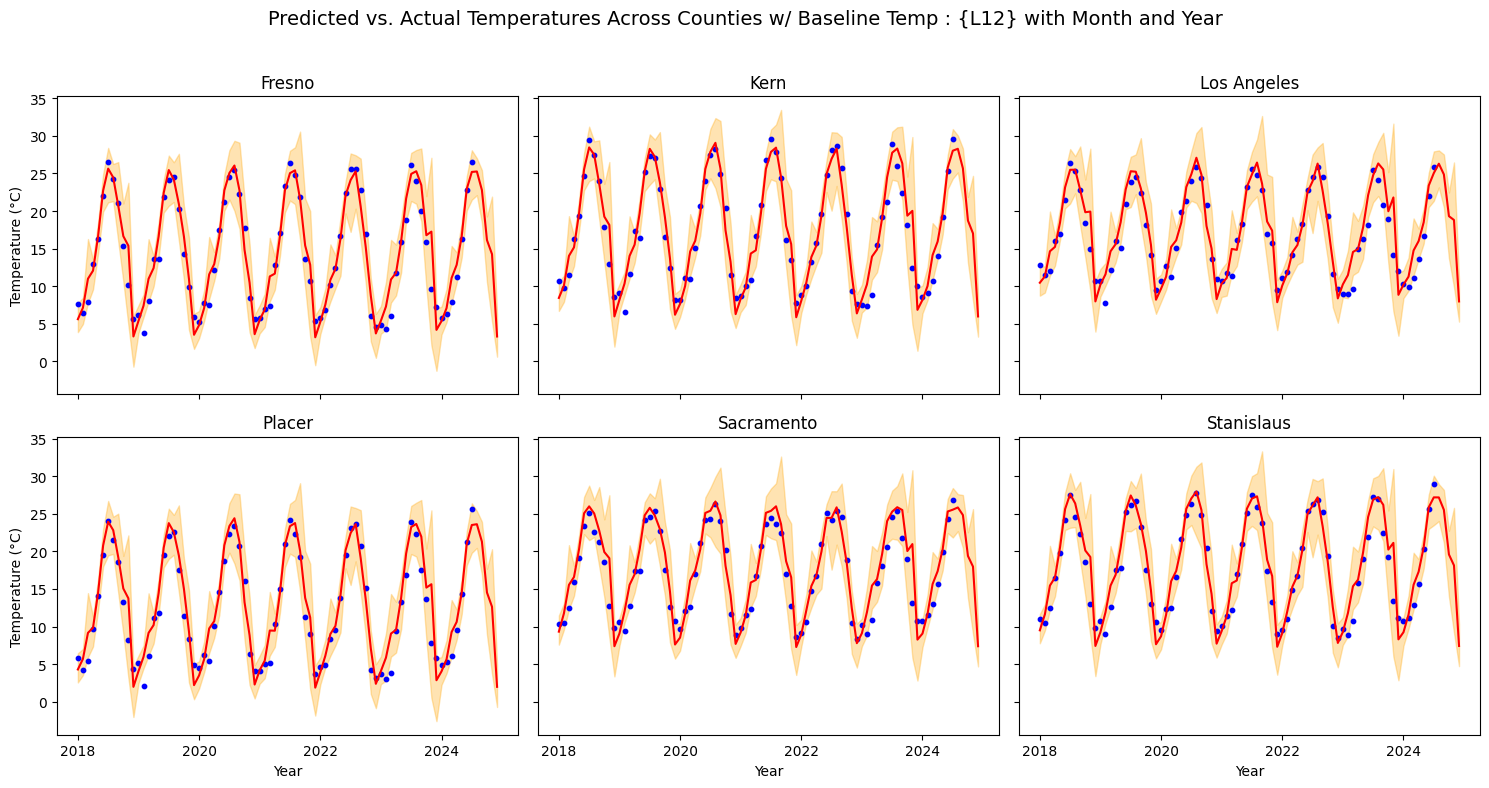

In [130]:
# Code to plot predicted vs. actual temperatures for 6 counties using the model trained on temp_anom_lag_12, month, and year
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure 'data' is already preprocessed from your anomaly calculations
# Extract historical temperature averages for each county and month
hist_temp_avg_lookup = data.set_index(["county", "month"])["hist_temp_avg"].to_dict()

# List of counties to plot in 2 rows and 3 columns
counties = ["Fresno", "Kern", "Los Angeles", "Placer", "Sacramento", "Stanislaus"]

# Create a 2x3 subplot layout (matching the original reference image)
fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten axes array for easy iteration

for i, county_name in enumerate(counties):
    ax = axes[i]

    # Filter actual observed temperatures for the county
    actual_temps_df = data[(data["county"] == county_name) & (data["year"] >= 2018) & (data["year"] <= 2024)]

    # Get the last available actual temperature date
    last_actual_year = actual_temps_df["year"].max()
    last_actual_month = actual_temps_df[actual_temps_df["year"] == last_actual_year]["month"].max()
    last_actual_date = last_actual_year + (last_actual_month - 1) / 12  # Convert to fractional year

    # Convert anomalies back to actual predicted temperatures
    mid_actual = np.array([mid[i] + hist_temp_avg_lookup.get((county_name, (i % 12) + 1), 0) for i in range(len(mid))])
    lo_actual = np.array([lo[i] + hist_temp_avg_lookup.get((county_name, (i % 12) + 1), 0) for i in range(len(lo))])
    hi_actual = np.array([hi[i] + hist_temp_avg_lookup.get((county_name, (i % 12) + 1), 0) for i in range(len(hi))])

    # Generate correct X-axis values based on validation data timestamps
    num_months = len(mid_actual)
    predicted_years = np.array([2018 + (i / 12) for i in range(num_months)])  # Aligns with validation years

    # Trim predictions beyond the last actual temperature data point
    valid_indices = predicted_years <= last_actual_date
    predicted_years = predicted_years[valid_indices]
    mid_actual = mid_actual[valid_indices]
    lo_actual = lo_actual[valid_indices]
    hi_actual = hi_actual[valid_indices]

    # Extract actual temperature values from the dataset
    actual_years = actual_temps_df["year"] + (actual_temps_df["month"] - 1) / 12  # Convert months into fractional years
    actual_temps = actual_temps_df["temperature"]

    # Plot predictions
    ax.plot(predicted_years, mid_actual, label="Predicted Median Temperature", color="red")
    ax.fill_between(predicted_years, lo_actual, hi_actual, color="orange", alpha=0.3, label="95% Confidence Interval")

    # Plot actual observed temperature values as blue dots
    ax.scatter(actual_years, actual_temps, color="blue", s=10)

    # Set title and labels
    ax.set_title(county_name, fontsize=12)
    if i % 3 == 0:
        ax.set_ylabel("Temperature (°C)")
    if i >= 3:
        ax.set_xlabel("Year")

    # Format x-axis ticks
    ax.set_xticks(np.arange(2018, 2025, step=2))

# Adjust layout
fig.suptitle("Predicted vs. Actual Temperatures Across Counties w/ Baseline Temp : {L12} with Month and Year", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [129]:
# Code to calculate the quantile score of the model trained on temp_anom_lag_12, month, and year
import numpy as np
import pandas as pd
import pickle

def quantile_score(y, y_quantiles, quantiles=np.arange(0.01, 1.0, 0.01)):
    y_quantiles = np.array(y_quantiles)  # Ensure correct type
    quantiles = np.array(quantiles)  # Ensure correct type

    # Compute absolute difference between actual and predicted quantiles
    diff = y - y_quantiles

    # Compute quantile loss (vectorized)
    error = np.where(diff >= 0, quantiles * np.abs(diff), (1 - quantiles) * np.abs(diff))

    return np.sum(error) / len(quantiles)

# Load the saved AutoBNN model
with open('temp_anom_lag_12_autobnn_model.pkl', 'rb') as f:
    loaded_est = pickle.load(f)

# print("✅ Model reloaded successfully!")

# Define test years for evaluation
test_years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Define quantiles for full distribution evaluation
quantiles = np.arange(0.01, 1.0, 0.01)  # Quantiles from 1% to 99%

# DataFrame to store results
results_list = []

for validation_year in test_years:
    # print(f"\n🔵 Evaluating Quantile Score for Test Year: {validation_year}")

    val_data = data[data["year"] == validation_year].copy()

    y_val = val_data["temp_anom"].values.astype(np.float32)

    # Reshape for consistency
    if y_val.ndim == 1:
        y_val = y_val[:, None]

    X_val = val_data[fit_vars]
    X_val_scaled = pd.DataFrame(scaler.transform(X_val), columns=fit_vars)

    x_val = np.arange(len(y_train), len(y_train) + len(y_val), dtype=np.float32) / x_scale

    x_val_combined = np.concatenate([x_val[:, None], X_val_scaled.to_numpy()], axis=1)

    quantile_preds = np.array(loaded_est.predict_quantiles(x_val_combined, q=quantiles * 100))  # Shape: (99, num_samples)

    quantile_preds = quantile_preds.T  

    if quantile_preds.shape != (len(y_val), len(quantiles)):
        raise ValueError(f"Shape mismatch after transposition: {quantile_preds.shape}, expected ({len(y_val)}, {len(quantiles)})")

    quantile_scores = np.array([
        quantile_score(y_true, y_quantiles, quantiles)
        for y_true, y_quantiles in zip(y_val.flatten(), quantile_preds)
    ])

    # Store results in a DataFrame
    results_df = pd.DataFrame({
        "county": val_data["county"].values,
        "year": validation_year,
        "month": val_data["month"].values,
        "temperature": val_data["temperature"].values,
        "quantile_score": quantile_scores
    })

    results_list.append(results_df)

combined_df = pd.concat(results_list, ignore_index=True)

combined_df["model_type"] = "AutoBNN - Temperature Anom Lags with Month and Year"

filtered_df = combined_df[combined_df["month"] >= 4]

df_summary_total = (
    filtered_df.groupby("model_type")
    .agg(total_quantile_score=("quantile_score", "sum"))
    .reset_index()
)

print(df_summary_total)

combined_df.to_csv("autobnn_quantile_scores.csv", index=False)
df_summary_total.to_csv("autobnn_total_quantile_score.csv", index=False)


✅ Model reloaded successfully!

🔵 Evaluating Quantile Score for Test Year: 2018

🔵 Evaluating Quantile Score for Test Year: 2019

🔵 Evaluating Quantile Score for Test Year: 2020

🔵 Evaluating Quantile Score for Test Year: 2021

🔵 Evaluating Quantile Score for Test Year: 2022

🔵 Evaluating Quantile Score for Test Year: 2023

🔵 Evaluating Quantile Score for Test Year: 2024
                                          model_type  total_quantile_score
0  AutoBNN - Temperature Anom Lags with Month and...            595.206152


# c) Model Trained on Temperature Lag (1,6,12) And Soil Temperature Lag 12 Features With 8 Ensembles with Simulations

In [81]:
import numpy as np
import pandas as pd

file_path = "/Users/zhenghuichen/Desktop/CS229 HW/CS229 Final Project/cleaned_weather_ds_v1.csv"
data2 = pd.read_csv(file_path)

########### Creating Lag Features ############

def create_lagged_variables(data, variables, lags, groupby_col="county"):
    """
    Function creates lagged features to prevent data leakage.

    Inputs:
        data: DataFrame containing the dataset
        variables: List of variables to create lagged features for
        lags: List of lag periods to apply
        groupby_col: Column to group by before applying lags (default is "county")

    Output:
        Updated DataFrame with new lagged features.
    """
    for var in variables:
        for lag in lags:
            data[f"{var}_L{lag}"] = data.groupby(groupby_col)[var].shift(lag)
    return data

# Define lag periods
temp_lags = [1, 6, 12]
soil_temp_lags = [12]

# Apply lagging for temperature and soil temperature
data2 = create_lagged_variables(data, ["temperature"], temp_lags)
data2 = create_lagged_variables(data, ["soil_temperature_layer_1"], soil_temp_lags)

# Sort data again after lagging
data2 = data2.sort_values(by=["year", "county", "month"])

########### Selecting Features for Training ############

# Define relevant features for modeling
fit_vars = ["year", "month", "temperature_L1", "temperature_L6", "temperature_L12", "soil_temperature_layer_1_L12"]

# Keep only data from 1991 onwards
data2 = data2[data["year"] >= 1991]

# Check the dataset
print("Features used for training:", fit_vars)
print(data.head())
print(data.shape)

# Check values of a column (everything exists)
print(data2["temperature_L1"].head())  # First 5 rows
print(data2["temperature_L1"].tail())  # Last 5 rows


Features used for training: ['year', 'month', 'temperature_L1', 'temperature_L6', 'temperature_L12', 'soil_temperature_layer_1_L12']
    Unnamed: 0  county  year  month  temperature  soil_temperature_layer_1  \
12       12372  Fresno  1991      1     4.310543                  4.357532   
13       12373  Fresno  1991      2     8.730227                  8.245149   
14       12374  Fresno  1991      3     5.374808                  7.242619   
15       12375  Fresno  1991      4     9.930297                 10.385421   
16       12376  Fresno  1991      5    12.710383                 13.787288   

     latitude   longitude  wind_speed  dewpoint_temperature  ...  \
12  36.758328 -119.648468    1.435220             -2.509409  ...   
13  36.758328 -119.648468    1.698744              0.824373  ...   
14  36.758328 -119.648468    2.243045              0.338214  ...   
15  36.758328 -119.648468    2.280564              1.021934  ...   
16  36.758328 -119.648468    2.356840              2.40827

In [88]:
fit_vars = ["year", "month", "temperature_L1", "temperature_L6", "temperature_L12", "soil_temperature_layer_1_L12"]

print(f"Features used for training: {fit_vars}")

# Initialize best model tracking
best_model = None
best_score = float("inf")

validation_years = range(2018, 2024)

for validation_year in validation_years:
    # print(f"\n🔵 Training on data up to {validation_year - 1}, Testing on {validation_year}")

    # Split into training and validation
    train_data = data2[data2["year"] < validation_year].copy()  # Copy to avoid modifying original
    val_data = data2[data2["year"] == validation_year].copy()

    # Extract target variable (temperature)
    y_train = train_data["temperature"].values.astype(np.float32)
    y_val = val_data["temperature"].values.astype(np.float32)

    y_train = y_train[:, None] if y_train.ndim == 1 else y_train
    y_val = y_val[:, None] if y_val.ndim == 1 else y_val

    # Extract features
    X_train = train_data[fit_vars].values.astype(np.float32)
    X_val = val_data[fit_vars].values.astype(np.float32)

    # Fix: Fill NaN values in lagged variables
    for var in fit_vars:
        train_data.loc[:, var] = train_data[var].fillna(train_data[var].mean())
        val_data.loc[:, var] = val_data[var].fillna(train_data[var].mean())

    # Scale features using RobustScaler
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(train_data[fit_vars])
    X_val_scaled = scaler.transform(val_data[fit_vars])

    # print("New X_train_scaled min/max:", np.min(X_train_scaled), np.max(X_train_scaled))

    # Generate time indices
    x_train = np.arange(len(y_train), dtype=np.float32)
    x_val = np.arange(len(y_train), len(y_train) + len(y_val), dtype=np.float32)

    # Normalize time indices (0 to 1)
    x_scale = x_train.max()
    x_train = x_train / x_scale
    x_val = x_val / x_scale

    # Define periodic component (yearly seasonality)
    one_year = jnp.array(12. / x_scale, dtype=jnp.float32)

    # Combine time indices with weather features for AutoBNN input
    x_train_combined = np.concatenate([x_train[:, None], X_train_scaled], axis=1)
    x_val_combined = np.concatenate([x_val[:, None], X_val_scaled], axis=1)

    seed = jax.random.PRNGKey(0)
    est = estimators.AutoBnnMapEstimator(
        model_or_name='sum_of_products',
        likelihood_model='normal_likelihood_logistic_noise',
        seed=seed,
        periods=(one_year,),
        num_particles=8,
    )

    est = est.fit(x_train_combined, y_train)

    lo, mid, p90, hi = est.predict_quantiles(x_val_combined, q=[2.5, 50.0, 90.0, 97.5])

    # Compute Negative Log-Likelihood (NLL) as evaluation metric
    nll = -np.mean(np.log(hi - lo))

    # print(f"🟢 Validation Year {validation_year}: NLL Score = {nll:.4f}")

    if nll < best_score:
        best_score = nll
        best_model = est
        # print(f"🔥 New Best Model Found (Year {validation_year}) with NLL = {best_score:.4f}")

with open("temp_L1_L6_L12_and_soil_temperature_layer_1_L12_autobnn_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# print("\n✅ Best Model Saved Successfully!")

Features used for training: ['year', 'month', 'temperature_L1', 'temperature_L6', 'temperature_L12', 'soil_temperature_layer_1_L12']

🔵 Training on data up to 2017, Testing on 2018
New X_train_scaled min/max: -1.4225991522345798 1.6518749742668393
🟢 Validation Year 2018: NLL Score = -1.6211
🔥 New Best Model Found (Year 2018) with NLL = -1.6211

🔵 Training on data up to 2018, Testing on 2019
New X_train_scaled min/max: -1.4200053410012428 1.6449734820072197
🟢 Validation Year 2019: NLL Score = -1.5493

🔵 Training on data up to 2019, Testing on 2020
New X_train_scaled min/max: -1.4256854892752688 1.650694015020637
🟢 Validation Year 2020: NLL Score = -1.6226
🔥 New Best Model Found (Year 2020) with NLL = -1.6226

🔵 Training on data up to 2020, Testing on 2021
New X_train_scaled min/max: -1.4220188081986103 1.642921947769356
🟢 Validation Year 2021: NLL Score = -1.6016

🔵 Training on data up to 2021, Testing on 2022
New X_train_scaled min/max: -1.4217199455102865 1.6375345497873892
🟢 Validati

In [90]:
# Code to check if model is successfully stored and can be reloaded 
with open("temp_L1_L6_L12_and_soil_temperature_layer_1_L12_autobnn_model.pkl", "rb") as f:
    loaded_est = pickle.load(f)

print("✅ Model reloaded successfully!")

try:
    lo, mid, p90, hi = loaded_est.predict_quantiles(x_val_combined, q=[2.5, 50.0, 90.0, 97.5])
    print(f"✅ Prediction shape: {mid.shape}")
except Exception as e:
    print(f"❌ Prediction failed: {e}")

print("Loaded model type:", type(loaded_est))
print("Model diagnostics keys:", loaded_est.diagnostics_.keys() if hasattr(loaded_est, 'diagnostics_') else "No diagnostics found")
print("Model periods:", loaded_est.periods if hasattr(loaded_est, 'periods') else "No periods found")


✅ Model reloaded successfully!
✅ Prediction shape: (156,)
Loaded model type: <class 'autobnn.estimators.AutoBnnMapEstimator'>
Model diagnostics keys: dict_keys(['loss'])
Model periods: (Array(0.00240433, dtype=float32),)


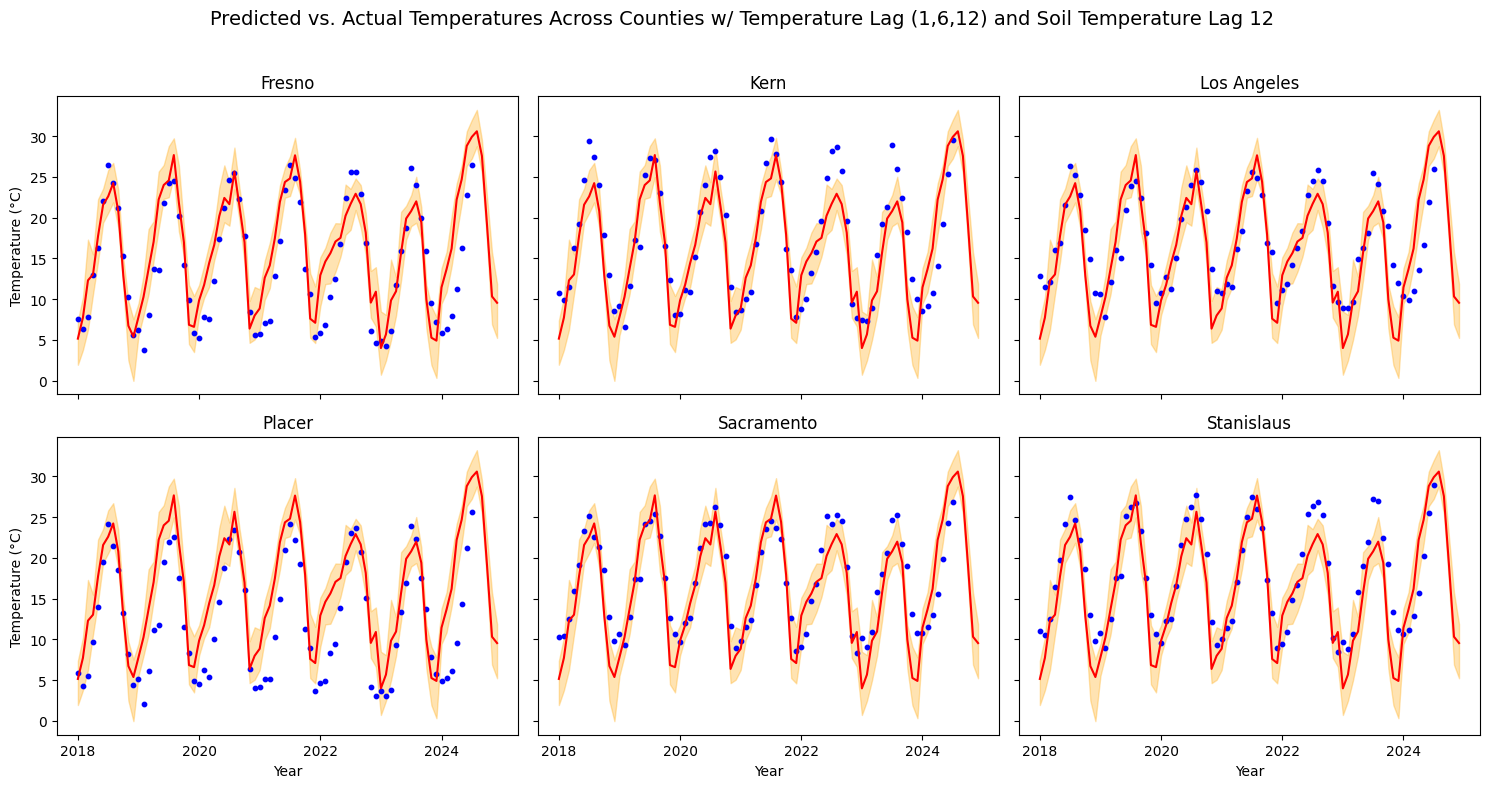

In [93]:
# Code to plot predicted vs. actual temperatures for 6 counties using the model trained on Temperature Lag (1,6,12) And Soil Temperature Lag 12
counties = ["Fresno", "Kern", "Los Angeles", "Placer", "Sacramento", "Stanislaus"]

fig, axes = plt.subplots(2, 3, figsize=(15, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten axes array for easy iteration

for i, county_name in enumerate(counties):
    ax = axes[i]

    actual_temps_df = data[(data["county"] == county_name) & (data["year"] >= 2018) & (data["year"] <= 2024)]

    last_actual_year = actual_temps_df["year"].max()
    last_actual_month = actual_temps_df[actual_temps_df["year"] == last_actual_year]["month"].max()
    last_actual_date = last_actual_year + (last_actual_month - 1) / 12  # Convert to fractional year

    num_months = len(mid)
    predicted_years = np.array([2018 + (j / 12) for j in range(num_months)])  # Aligns with validation years

    valid_indices = predicted_years <= last_actual_date
    predicted_years = predicted_years[valid_indices]
    mid = mid[valid_indices]
    lo = lo[valid_indices]
    hi = hi[valid_indices]

    actual_years = actual_temps_df["year"] + (actual_temps_df["month"] - 1) / 12  # Convert months into fractional years
    actual_temps = actual_temps_df["temperature"]

    ax.plot(predicted_years, mid, label="Predicted Median Temperature", color="red")
    ax.fill_between(predicted_years, lo, hi, color="orange", alpha=0.3, label="95% Confidence Interval")

    ax.scatter(actual_years, actual_temps, color="blue", s=10, label="Observed Temperature")

    ax.set_title(county_name, fontsize=12)
    if i % 3 == 0:
        ax.set_ylabel("Temperature (°C)")
    if i >= 3:
        ax.set_xlabel("Year")

    ax.set_xticks(np.arange(2018, 2025, step=2))

fig.suptitle("Predicted vs. Actual Temperatures Across Counties w/ Temperature Lag (1,6,12) and Soil Temperature Lag 12 ", fontsize=14)
fig.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

# Data Simulation for Temperature Lag (1,6,12), and Soil_Temperature Lag 12 For All Counties #

In [152]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

with open("temp_L1_L6_L12_and_soil_temperature_layer_1_L12_autobnn_model.pkl", "rb") as f:
    best_model = pickle.load(f)

# print("✅ Model reloaded successfully for simulations!")

N_simulations = 10  
test_years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]  
counties = data2["county"].unique().tolist()  

fit_vars = ["year", "month", "temperature_L1", "temperature_L6", "temperature_L12", "soil_temperature_layer_1_L12"]

missing_cols = [col for col in fit_vars if col not in data2.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in data2: {missing_cols}")

scaler = RobustScaler()
scaler.fit(data2[fit_vars])  # Fit on the entire dataset for consistency

all_simulations_results = []

for test_year in test_years:
    # print(f"\n🔵 Simulating for Test Year: {test_year}")

    for county_name in counties:
        # print(f"🔹 Simulating for County: {county_name}")

        county_data = data2[(data2["year"] == test_year) & (data2["county"] == county_name)].copy()

        if county_data.empty:
            # print(f"⚠️ No data for {county_name} in {test_year}. Skipping...")
            continue

        if "hist_temp_avg" not in county_data.columns:
            # print(f"⚠️ Warning: 'hist_temp_avg' column is missing for {county_name}, {test_year}. Computing it from historical data...")

            for month in range(4, 13):
                hist_temp_avg_lookup = data2[
                    (data2["county"] == county_name) & 
                    (data2["year"] < test_year) & 
                    (data2["month"] == month)
                ]["temperature"].mean()

                # If no historical data is found, fall back to the county mean
                if pd.isna(hist_temp_avg_lookup):
                    hist_temp_avg_lookup = data2[
                        (data2["county"] == county_name) & (data2["year"] < test_year)
                    ]["temperature"].mean()

                county_data.loc[county_data["month"] == month, "hist_temp_avg"] = hist_temp_avg_lookup

        simulation_results = []

        months = [4, 5, 6, 7, 8, 9, 10, 11, 12]

        for simulation in range(N_simulations):
            if simulation % 10 == 0:  # Print every 10 iterations to avoid spam
                print(f"Running Simulation {simulation+1}/{N_simulations} for {county_name}, {test_year}")

            simulated_data = county_data.copy()

            for month in months:
                X_val = simulated_data.loc[simulated_data["month"] == month, fit_vars].copy()

                for col in fit_vars:
                    X_val[col] = X_val[col].fillna(data2[col].mean())

                X_val_scaled = scaler.transform(X_val)

                time_index = np.full((X_val.shape[0], 1), month / 12.0, dtype=np.float32)

                X_val_combined = np.concatenate([time_index, X_val_scaled], axis=1)

                try:
                    params = best_model.predict(X_val_combined)  # Returns shape (N, 8)
                except Exception as e:
                    print(f"❌ Prediction failed for {county_name}, {test_year}, Month {month}")
                    print(f"X_val_combined shape: {X_val_combined.shape}")
                    print(f"Error: {e}")
                    continue

                mu = np.median(params, axis=1).flatten()[0]  # Take median across ensembles
                sigma = np.median(np.std(params, axis=1)).flatten()[0]  # Take median of standard deviations

                # print(f"✅ Computed Mu: {mu}, Sigma: {sigma} for {county_name}, {test_year}, Month {month}")

                hist_temp_avg = simulated_data.loc[simulated_data["month"] == month, "hist_temp_avg"].values.flatten()[0]
                simulated_temp_anom = np.random.normal(mu, sigma)
                simulated_temperature = simulated_temp_anom + hist_temp_avg

                simulated_data.loc[simulated_data["month"] == month, "mu"] = mu
                simulated_data.loc[simulated_data["month"] == month, "sigma"] = sigma
                simulated_data.loc[simulated_data["month"] == month, "simulated_temp_anom"] = simulated_temp_anom
                simulated_data.loc[simulated_data["month"] == month, "simulated_temperature"] = simulated_temperature
                simulated_data.loc[simulated_data["month"] == month, "simulation_number"] = simulation + 1

            simulation_results.append(simulated_data)

        combined_simulation_df = pd.concat(simulation_results, ignore_index=True)
        all_simulations_results.append(combined_simulation_df)

all_simulation_results_df = pd.concat(all_simulations_results, ignore_index=True)

all_simulation_results_df = all_simulation_results_df[[
    "county", "year", "month", "temperature",
    "simulated_temperature",
    "mu", "sigma", "simulation_number", "hist_temp_avg"
]]

all_simulation_results_df.to_csv("simulated_weather_data_final.csv", index=False)

# print("\n✅ Weather data simulations completed!")


Running Simulation 1/10 for Fresno, 2018


KeyboardInterrupt: 

# Testing Simulation Code on Fresno County For One Year #

In [146]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

with open("temp_L1_L6_L12_and_soil_temperature_layer_1_L12_autobnn_model.pkl", "rb") as f:
    best_model = pickle.load(f)

print("✅ Model reloaded successfully for single county/year simulation!")

county_name = "Fresno"  
test_year = 2018         
N_simulations = 100      

fit_vars = ["year", "month", "temperature_L1", "temperature_L6", "temperature_L12", "soil_temperature_layer_1_L12"]

county_data = data2[(data2["year"] == test_year) & (data2["county"] == county_name)].copy()

if county_data.empty:
    print(f"⚠️ No data for {county_name} in {test_year}. Exiting...")
    exit()

if "hist_temp_avg" not in county_data.columns:
    # print(f"⚠️ Warning: 'hist_temp_avg' column is missing. Computing it from historical data...")
    for month in range(4, 13):
        hist_temp_avg_lookup = data2[
            (data2["county"] == county_name) & 
            (data2["year"] < test_year) & 
            (data2["month"] == month)
        ]["temperature"].mean()

        # If no historical data is found, fall back to the mean for that county
        if pd.isna(hist_temp_avg_lookup):
            # print(f"⚠️ No historical data found for {county_name}, month {month}. Using overall county mean.")
            hist_temp_avg_lookup = data2[
                (data2["county"] == county_name) & (data2["year"] < test_year)
            ]["temperature"].mean()

        county_data.loc[county_data["month"] == month, "hist_temp_avg"] = hist_temp_avg_lookup

months = [4, 5, 6, 7, 8, 9, 10, 11, 12]

simulation_results = []

scaler = RobustScaler()
scaler.fit(data2[fit_vars])  # Fit the scaler using the **entire dataset**, ensuring consistency

for simulation in range(N_simulations):
    print(f"🔄 Running Simulation {simulation+1}/{N_simulations} for {county_name}, {test_year}")

    simulated_data = county_data.copy()

    for month in months:
        X_val = simulated_data.loc[simulated_data["month"] == month, fit_vars].copy()

        for col in fit_vars:
            X_val[col] = X_val[col].fillna(data2[col].mean())

        X_val_scaled = scaler.transform(X_val)

        time_index = np.full((X_val.shape[0], 1), month / 12.0, dtype=np.float32)

        X_val_combined = np.concatenate([time_index, X_val_scaled], axis=1)

        try:
            params = best_model.predict(X_val_combined) 
            # print(f"🔍 Model Prediction Output (params) for {county_name}, {test_year}, Month {month}: {params}")
        except Exception as e:
            print(f"❌ Prediction failed for {county_name}, {test_year}, Month {month}")
            print(f"X_val_combined shape: {X_val_combined.shape}")
            print(f"Error: {e}")
            continue

        mu = np.median(params, axis=1).flatten()[0]  # Take median across ensembles, ensure scalar
        sigma = np.median(np.std(params, axis=1)).flatten()[0]  # Take median of standard deviations

        # print(f"✅ Computed Mu: {mu}, Sigma: {sigma} for {county_name}, {test_year}, Month {month}")

        if sigma <= 0:
            print(f"❌ Warning: Sigma is non-positive! This is incorrect.")
            raise ValueError("❌ Sigma should always be positive!")

        hist_temp_avg = simulated_data.loc[simulated_data["month"] == month, "hist_temp_avg"].values.flatten()[0]
        simulated_temp_anom = np.random.normal(mu, sigma)
        simulated_temperature = simulated_temp_anom + hist_temp_avg

        simulated_data.loc[simulated_data["month"] == month, "mu"] = mu
        simulated_data.loc[simulated_data["month"] == month, "sigma"] = sigma
        simulated_data.loc[simulated_data["month"] == month, "simulated_temp_anom"] = simulated_temp_anom
        simulated_data.loc[simulated_data["month"] == month, "simulated_temperature"] = simulated_temperature
        simulated_data.loc[simulated_data["month"] == month, "simulation_number"] = simulation + 1

    simulation_results.append(simulated_data)

final_simulation_df = pd.concat(simulation_results, ignore_index=True)

final_simulation_df = final_simulation_df[[
    "county", "year", "month", "temperature",
    "simulated_temperature",
    "mu", "sigma", "simulation_number", "hist_temp_avg"
]]

output_filename = f"simulated_weather_{county_name}_{test_year}.csv"
final_simulation_df.to_csv(output_filename, index=False)
# print(f"\n✅ Simulation complete! Results saved to: {output_filename}")


✅ Model reloaded successfully for single county/year simulation!
⚠️ Warning: 'hist_temp_avg' column is missing. Computing it from historical data...
🔄 Running Simulation 1/100 for Fresno, 2018
🔄 Running Simulation 2/100 for Fresno, 2018
🔄 Running Simulation 3/100 for Fresno, 2018
🔄 Running Simulation 4/100 for Fresno, 2018
🔄 Running Simulation 5/100 for Fresno, 2018
🔄 Running Simulation 6/100 for Fresno, 2018
🔄 Running Simulation 7/100 for Fresno, 2018
🔄 Running Simulation 8/100 for Fresno, 2018
🔄 Running Simulation 9/100 for Fresno, 2018
🔄 Running Simulation 10/100 for Fresno, 2018
🔄 Running Simulation 11/100 for Fresno, 2018
🔄 Running Simulation 12/100 for Fresno, 2018
🔄 Running Simulation 13/100 for Fresno, 2018
🔄 Running Simulation 14/100 for Fresno, 2018
🔄 Running Simulation 15/100 for Fresno, 2018
🔄 Running Simulation 16/100 for Fresno, 2018
🔄 Running Simulation 17/100 for Fresno, 2018
🔄 Running Simulation 18/100 for Fresno, 2018
🔄 Running Simulation 19/100 for Fresno, 2018
🔄 Run

# Testing Simulation Code on Fresno County From 2018 - 2024

In [147]:
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

with open("temp_L1_L6_L12_and_soil_temperature_layer_1_L12_autobnn_model.pkl", "rb") as f:
    best_model = pickle.load(f)

# print("✅ Model reloaded successfully for multi-year simulation!")

# Define simulation parameters
county_name = "Fresno"  
test_years = [2018, 2019, 2020, 2021, 2022, 2023, 2024]  
N_simulations = 250  

# Define feature set
fit_vars = ["year", "month", "temperature_L1", "temperature_L6", "temperature_L12", "soil_temperature_layer_1_L12"]

# Ensure feature columns exist in dataset
missing_cols = [col for col in fit_vars if col not in data2.columns]
if missing_cols:
    raise KeyError(f"Missing required columns in data2: {missing_cols}")

# Initialize RobustScaler using training data for proper scaling
scaler = RobustScaler()
scaler.fit(data2[fit_vars])  # Fit the scaler using the entire dataset for consistency

all_simulations_results = []

for test_year in test_years:
    # print(f"\n🔵 Simulating for Test Year: {test_year} in County: {county_name}")

    county_data = data2[(data2["year"] == test_year) & (data2["county"] == county_name)].copy()

    if county_data.empty:
        # print(f"⚠️ No data for {county_name} in {test_year}. Skipping...")
        continue

    if "hist_temp_avg" not in county_data.columns:
        # print(f"⚠️ Warning: 'hist_temp_avg' column is missing for {county_name}, {test_year}. Computing it from historical data...")
        
        for month in range(4, 13):
            hist_temp_avg_lookup = data2[
                (data2["county"] == county_name) & 
                (data2["year"] < test_year) & 
                (data2["month"] == month)
            ]["temperature"].mean()

            # If no historical data is found, fall back to the mean for that county
            if pd.isna(hist_temp_avg_lookup):
                hist_temp_avg_lookup = data2[
                    (data2["county"] == county_name) & (data2["year"] < test_year)
                ]["temperature"].mean()

            county_data.loc[county_data["month"] == month, "hist_temp_avg"] = hist_temp_avg_lookup

    months = [4, 5, 6, 7, 8, 9, 10, 11, 12]

    simulation_results = []

    for simulation in range(N_simulations):
        if simulation % 10 == 0:  # Print every 10 iterations to avoid spam
            print(f"Running Simulation {simulation+1}/{N_simulations} for {county_name}, {test_year}")

        # Copy initial data for simulation
        simulated_data = county_data.copy()

        for month in months:
            X_val = simulated_data.loc[simulated_data["month"] == month, fit_vars].copy()

            for col in fit_vars:
                X_val[col] = X_val[col].fillna(data2[col].mean())

            X_val_scaled = scaler.transform(X_val)

            time_index = np.full((X_val.shape[0], 1), month / 12.0, dtype=np.float32)

            X_val_combined = np.concatenate([time_index, X_val_scaled], axis=1)

            try:
                params = best_model.predict(X_val_combined)  # Returns shape (N, 8)
            except Exception as e:
                # print(f"❌ Prediction failed for {county_name}, {test_year}, Month {month}")
                # print(f"X_val_combined shape: {X_val_combined.shape}")
                # print(f"Error: {e}")
                continue

            # Compute median mu and sigma across ensemble members
            mu = np.median(params, axis=1).flatten()[0]  # Take median across ensembles
            sigma = np.median(np.std(params, axis=1)).flatten()[0]  # Take median of standard deviations

            # Compute actual simulated temperature
            hist_temp_avg = simulated_data.loc[simulated_data["month"] == month, "hist_temp_avg"].values.flatten()[0]
            simulated_temp_anom = np.random.normal(mu, sigma)
            simulated_temperature = simulated_temp_anom + hist_temp_avg

            # Store predictions
            simulated_data.loc[simulated_data["month"] == month, "mu"] = mu
            simulated_data.loc[simulated_data["month"] == month, "sigma"] = sigma
            simulated_data.loc[simulated_data["month"] == month, "simulated_temp_anom"] = simulated_temp_anom
            simulated_data.loc[simulated_data["month"] == month, "simulated_temperature"] = simulated_temperature
            simulated_data.loc[simulated_data["month"] == month, "simulation_number"] = simulation + 1

        simulation_results.append(simulated_data)

    combined_simulation_df = pd.concat(simulation_results, ignore_index=True)
    all_simulations_results.append(combined_simulation_df)

final_simulation_df = pd.concat(all_simulations_results, ignore_index=True)

final_simulation_df = final_simulation_df[[
    "county", "year", "month", "temperature",
    "simulated_temperature",
    "mu", "sigma", "simulation_number", "hist_temp_avg"
]]

# ✅ Save to CSV
output_filename = f"simulated_weather_250_samples_{county_name}_2018_2024.csv"
final_simulation_df.to_csv(output_filename, index=False)

# print(f"\n✅ Simulation complete! Results saved to: {output_filename}")


✅ Model reloaded successfully for multi-year simulation!

🔵 Simulating for Test Year: 2018 in County: Fresno
⚠️ Warning: 'hist_temp_avg' column is missing for Fresno, 2018. Computing it from historical data...
🔄 Running Simulation 1/250 for Fresno, 2018
🔄 Running Simulation 11/250 for Fresno, 2018
🔄 Running Simulation 21/250 for Fresno, 2018
🔄 Running Simulation 31/250 for Fresno, 2018
🔄 Running Simulation 41/250 for Fresno, 2018
🔄 Running Simulation 51/250 for Fresno, 2018
🔄 Running Simulation 61/250 for Fresno, 2018
🔄 Running Simulation 71/250 for Fresno, 2018
🔄 Running Simulation 81/250 for Fresno, 2018
🔄 Running Simulation 91/250 for Fresno, 2018
🔄 Running Simulation 101/250 for Fresno, 2018
🔄 Running Simulation 111/250 for Fresno, 2018
🔄 Running Simulation 121/250 for Fresno, 2018
🔄 Running Simulation 131/250 for Fresno, 2018
🔄 Running Simulation 141/250 for Fresno, 2018
🔄 Running Simulation 151/250 for Fresno, 2018
🔄 Running Simulation 161/250 for Fresno, 2018
🔄 Running Simulatio

# Calculating Quantile Score using Simulated Values from Temperature Lag (1,6,12) and Soil_Temperature Lag 12 Model

In [151]:
import numpy as np
import pandas as pd

def quantile_score(y, y_quantiles, quantiles=np.arange(0.01, 1.0, 0.01)):
    y_quantiles = np.array(y_quantiles)  # Ensure correct type
    quantiles = np.array(quantiles)  # Ensure correct type

    # Compute absolute difference between actual and predicted quantiles
    diff = y - y_quantiles

    # Compute quantile loss (vectorized)
    error = np.where(diff >= 0, quantiles * np.abs(diff), (1 - quantiles) * np.abs(diff))

    return np.sum(error) / len(quantiles)


simulated_data_df = pd.read_csv("simulated_weather_250_samples_Fresno_2018_2024.csv")

simulated_data_df = simulated_data_df[[
    "county", "year", "month", "temperature",
    "simulated_temperature", "simulation_number"
]]

quantiles = np.arange(0.01, 1.0, 0.01)

results_list = []

year_month_combinations = simulated_data_df[["year", "month"]].drop_duplicates()

for _, row in year_month_combinations.iterrows():
    test_year = row["year"]
    month = row["month"]
    # print(f"🔵 Processing Year: {test_year}, Month: {month}")

    # Filter for current year and month
    cond = (simulated_data_df["year"] == test_year) & (simulated_data_df["month"] == month)
    month_data = simulated_data_df[cond]

    # Extract all simulated temperatures for the given month
    sim_temp_np = month_data["simulated_temperature"].to_numpy()

    # Compute empirical quantiles
    if len(sim_temp_np) > 0:
        ordered_quantiles = np.quantile(sim_temp_np, quantiles)

        result = {
            "year": test_year,
            "month": month
        }

        if test_year <= 2024:
            observed_temp_series = month_data["temperature"]
            observed_temp = observed_temp_series.iloc[0]  # Take first observed value

            result["temperature"] = observed_temp

            q_score = quantile_score(
                observed_temp,
                ordered_quantiles
            )

            result["quantile_score"] = q_score
        else:
            result["temperature"] = np.nan
            result["quantile_score"] = np.nan

        results_list.append(result)

# Convert results to a DataFrame
quantile_scores_df = pd.DataFrame(results_list)

# Manually add a model type column
quantile_scores_df["model_type"] = "Simulated AutoBNN - Temperature Lags"

# Filter for months April - December (same as AutoBNN evaluation)
filtered_df = quantile_scores_df[quantile_scores_df["month"] >= 4]

# Compute total quantile score by summing across all months and counties
df_summary_total = (
    filtered_df.groupby("model_type")
    .agg(total_quantile_score=("quantile_score", "sum"))
    .reset_index()
)

# print("\n✅ Total Quantile Score for Simulated AutoBNN Model:")
# print(df_summary_total)

quantile_scores_df.to_csv("simulated_quantile_scores.csv", index=False)
df_summary_total.to_csv("simulated_total_quantile_score.csv", index=False)

# print("\n✅ Quantile Score Calculation Completed!")

🔵 Processing Year: 2018, Month: 1
🔵 Processing Year: 2018, Month: 2
🔵 Processing Year: 2018, Month: 3
🔵 Processing Year: 2018, Month: 4
🔵 Processing Year: 2018, Month: 5
🔵 Processing Year: 2018, Month: 6
🔵 Processing Year: 2018, Month: 7
🔵 Processing Year: 2018, Month: 8
🔵 Processing Year: 2018, Month: 9
🔵 Processing Year: 2018, Month: 10
🔵 Processing Year: 2018, Month: 11
🔵 Processing Year: 2018, Month: 12
🔵 Processing Year: 2019, Month: 1
🔵 Processing Year: 2019, Month: 2
🔵 Processing Year: 2019, Month: 3
🔵 Processing Year: 2019, Month: 4
🔵 Processing Year: 2019, Month: 5
🔵 Processing Year: 2019, Month: 6
🔵 Processing Year: 2019, Month: 7
🔵 Processing Year: 2019, Month: 8
🔵 Processing Year: 2019, Month: 9
🔵 Processing Year: 2019, Month: 10
🔵 Processing Year: 2019, Month: 11
🔵 Processing Year: 2019, Month: 12
🔵 Processing Year: 2020, Month: 1
🔵 Processing Year: 2020, Month: 2
🔵 Processing Year: 2020, Month: 3
🔵 Processing Year: 2020, Month: 4
🔵 Processing Year: 2020, Month: 5
🔵 Proces